![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [5]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [6]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

<Axes: title={'center': 'Sentiminetos por aerolínea'}, xlabel='airline'>

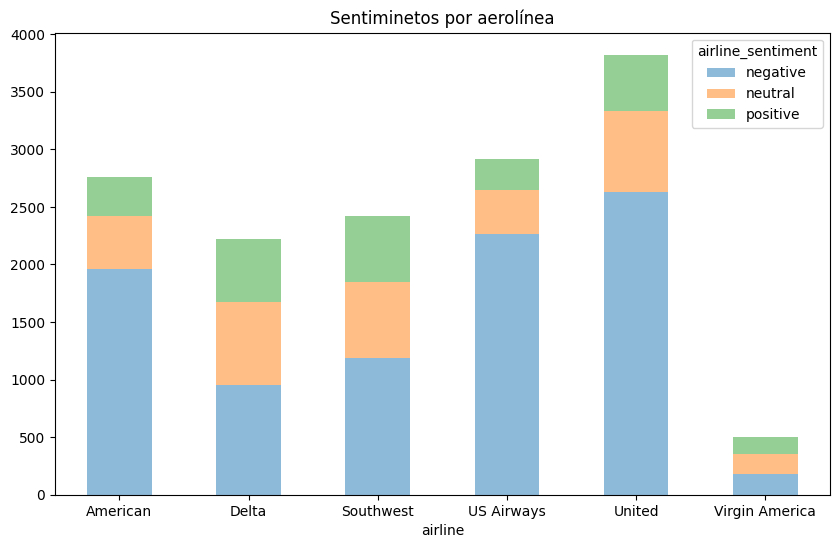

In [7]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

In [8]:
tweets_filtered = tweets[tweets['airline_sentiment'] == 'negative']
print(tweets_filtered[['text']])

                                                                 text
tweet_id                                                             
570301031407624196  @VirginAmerica it's really aggressive to blast...
570300817074462722  @VirginAmerica and it's a really big bad thing...
570300767074181121  @VirginAmerica seriously would pay $30 a fligh...
570282469121007616      @VirginAmerica SFO-PDX schedule is still MIA.
570276917301137409  @VirginAmerica  I flew from NYC to SFO last we...
...                                                               ...
569588464896876545  @AmericanAir thx for nothing on getting us out...
569587705937600512  @AmericanAir my flight was Cancelled Flightled...
569587691626622976         @AmericanAir right on cue with the delays👌
569587371693355008  @AmericanAir leaving over 20 minutes Late Flig...
569587188687634433  @AmericanAir you have my money, you change my ...

[9178 rows x 1 columns]


### Liberias y Variables de interés y predicción

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [10]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [11]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
X_train

tweet_id
569577005278064640                          @JetBlue of course I am!!✈️
569633482915209216    @AmericanAir complt incompetence on flt 295.La...
567829997668470785    @SouthwestAir Flight 4968 (N8325D) departs @MC...
569725021951791104    @USAirways does anyone from your airline know ...
567852278893416448                           @united I Want a Plane dad
                                            ...                        
569266206596734976    @SouthwestAir replacing @vitaminwater with bee...
569867943888056320    @AmericanAir at LAX and your service reps just...
569151232738095105    @SouthwestAir Been on hold for over an hour - ...
570049697924009984    @united we would...how do I contact you to dis...
569705380282019841    @JetBlue that's ok! It just sure seemed like i...
Name: text, Length: 9808, dtype: object

In [13]:
y_train

tweet_id
569577005278064640    0
569633482915209216   -1
567829997668470785   -1
569725021951791104   -1
567852278893416448    0
                     ..
569266206596734976    1
569867943888056320   -1
569151232738095105   -1
570049697924009984   -1
569705380282019841    0
Name: airline_sentiment, Length: 9808, dtype: int64

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [14]:
# Celda 1
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

cv1 = CountVectorizer(lowercase=True)

In [15]:
X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1 = cv1.transform(X_test)
X_train_cv1.shape

(9808, 12056)

In [16]:
cv1.vocabulary_

{'jetblue': 6206,
 'of': 7768,
 'course': 3393,
 'am': 1680,
 'americanair': 1695,
 'complt': 3218,
 'incompetence': 5893,
 'on': 7815,
 'flt': 4790,
 '295': 508,
 'lav': 6525,
 'delay': 3661,
 'from': 4975,
 'pln': 8327,
 'that': 10546,
 'lnded': 6713,
 'last': 6503,
 'nite': 7566,
 'no': 7580,
 'internet': 6039,
 'and': 1729,
 'poor': 8364,
 'svc': 10323,
 'not': 7655,
 'what': 11670,
 'expect': 4460,
 'southwestair': 9955,
 'flight': 4735,
 '4968': 846,
 'n8325d': 7405,
 'departs': 3705,
 'mco': 7032,
 'enroute': 4292,
 'to': 10724,
 'no_airport': 7582,
 'http': 5713,
 'co': 3090,
 'fd4snvkiem': 4597,
 'usairways': 11325,
 'does': 3962,
 'anyone': 1798,
 'your': 11982,
 'airline': 1584,
 'know': 6426,
 'how': 5694,
 'do': 3953,
 'their': 10562,
 'job': 6254,
 'united': 11192,
 'want': 11570,
 'plane': 8290,
 'dad': 3546,
 'my': 7375,
 '386': 664,
 'dallas': 3556,
 'jacksonville': 6151,
 'fl': 4711,
 'has': 5448,
 'been': 2231,
 'cancelled': 2710,
 'flightled': 4765,
 'one': 7821,
 '

In [17]:
rf1 = RandomForestClassifier()
rf1.fit(X_train_cv1, y_train)

RandomForestClassifier()

In [18]:
predict_rf1 = rf1.predict(X_test_cv1)

In [19]:

from sklearn.metrics import accuracy_score
accuracy_rf1 = accuracy_score(y_test, predict_rf1)
print("Accuracy del modelo Random Forest:", accuracy_rf1)

Accuracy del modelo Random Forest: 0.7725579470198676


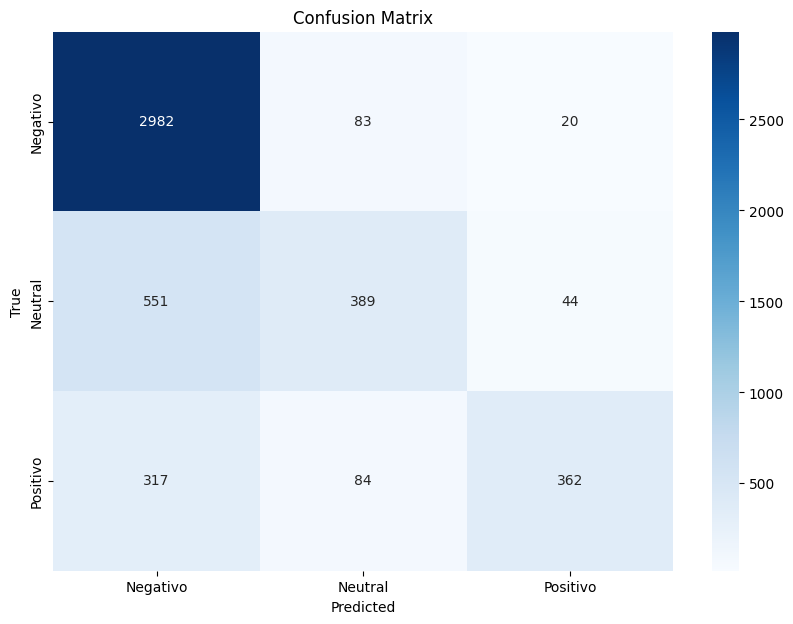

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

conf_matrix_modelo1 = confusion_matrix(y_test, predict_rf1)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_modelo1, annot=True, fmt='g', cmap='Blues', xticklabels=['Negativo', 'Neutral', 'Positivo'], yticklabels=['Negativo', 'Neutral', 'Positivo'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [21]:
# Celda 2
cv2 = CountVectorizer(lowercase=True, stop_words='english')
X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2 = cv2.transform(X_test)
X_train_cv2.shape

(9808, 11777)

In [22]:
cv2.vocabulary_

{'jetblue': 6081,
 'course': 3335,
 'americanair': 1680,
 'complt': 3163,
 'incompetence': 5775,
 'flt': 4701,
 '295': 508,
 'lav': 6398,
 'delay': 3601,
 'pln': 8147,
 'lnded': 6584,
 'nite': 7417,
 'internet': 5919,
 'poor': 8184,
 'svc': 10116,
 'expect': 4378,
 'southwestair': 9750,
 'flight': 4646,
 '4968': 846,
 'n8325d': 7261,
 'departs': 3645,
 'mco': 6900,
 'enroute': 4218,
 'no_airport': 7432,
 'http': 5599,
 'fd4snvkiem': 4515,
 'usairways': 11078,
 'does': 3899,
 'airline': 1578,
 'know': 6300,
 'job': 6129,
 'united': 10949,
 'want': 11321,
 'plane': 8111,
 'dad': 3487,
 '386': 664,
 'dallas': 3497,
 'jacksonville': 6026,
 'fl': 4622,
 'cancelled': 2658,
 'flightled': 4676,
 'notified': 7519,
 'going': 5114,
 'trying': 10673,
 'make': 6785,
 'probably': 8348,
 'late': 6384,
 'did': 3721,
 'email': 4147,
 'pittsburgh': 8091,
 'international': 5917,
 'look': 6638,
 'forward': 4815,
 'jb': 6057,
 'rt': 9092,
 'bostongarden': 2403,
 'looking': 6642,
 'welcoming': 11393,
 'onbo

In [23]:
#Verificar las stopwords eliminadas
cv2.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [24]:
rf2 = RandomForestClassifier()
rf2.fit(X_train_cv2, y_train)
predict_rf2 = rf2.predict(X_test_cv2)

In [25]:
accuracy_rf2 = accuracy_score(y_test, predict_rf2)
print("Accuracy del modelo Random Forest:", accuracy_rf2)

Accuracy del modelo Random Forest: 0.7649006622516556


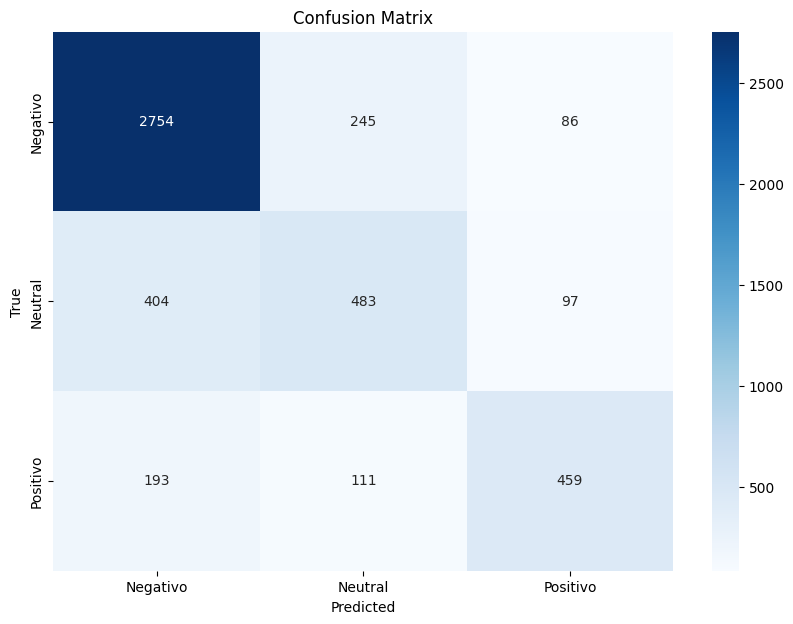

In [26]:
conf_matrix_modelo2 = confusion_matrix(y_test, predict_rf2)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_modelo2, annot=True, fmt='g', cmap='Blues', xticklabels=['Negativo', 'Neutral', 'Positivo'], yticklabels=['Negativo', 'Neutral', 'Positivo'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [27]:
# Celda 3
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [28]:
#Asumimos que las palabras son verbos

def split_into_lemmas_ver(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word,pos='v') for word in words]

In [29]:
cv3 = CountVectorizer(lowercase=True,analyzer=split_into_lemmas_ver)

In [30]:

X_train_cv3 = cv3.fit_transform(X_train)
X_test_cv3 = cv3.transform(X_test)
X_train_cv3.shape

(9808, 19380)

In [31]:
rf3 = RandomForestClassifier()
rf3.fit(X_train_cv3, y_train)
predict_rf3 = rf3.predict(X_test_cv3)

In [32]:
accuracy_rf3 = accuracy_score(y_test, predict_rf3)
print("Accuracy del modelo Random Forest:", accuracy_rf3)

Accuracy del modelo Random Forest: 0.7622102649006622


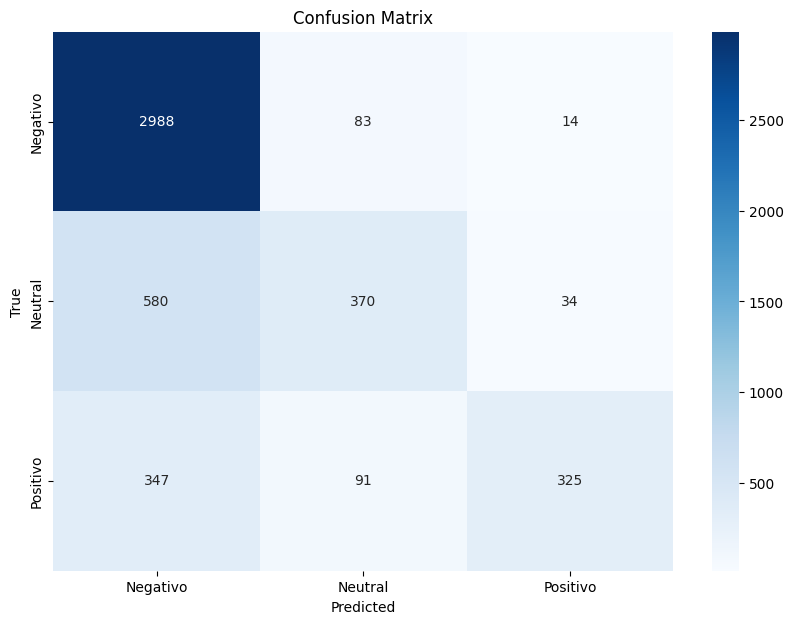

In [33]:
conf_matrix_modelo3 = confusion_matrix(y_test, predict_rf3)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_modelo3, annot=True, fmt='g', cmap='Blues', xticklabels=['Negativo', 'Neutral', 'Positivo'], yticklabels=['Negativo', 'Neutral', 'Positivo'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [34]:
# Celda 4
# Descargar los recursos necesarios de NLTK

cv4 = CountVectorizer(lowercase=True, stop_words='english',analyzer=split_into_lemmas_ver)

X_train_cv4 = cv4.fit_transform(X_train)
X_test_cv4 = cv4.transform(X_test)

rf4 = RandomForestClassifier()
rf4.fit(X_train_cv4, y_train)
predict_rf4 = rf4.predict(X_test_cv4)

accuracy_rf4 = accuracy_score(y_test, predict_rf4)
print("Accuracy del modelo Random Forest:", accuracy_rf4)




Accuracy del modelo Random Forest: 0.7605546357615894


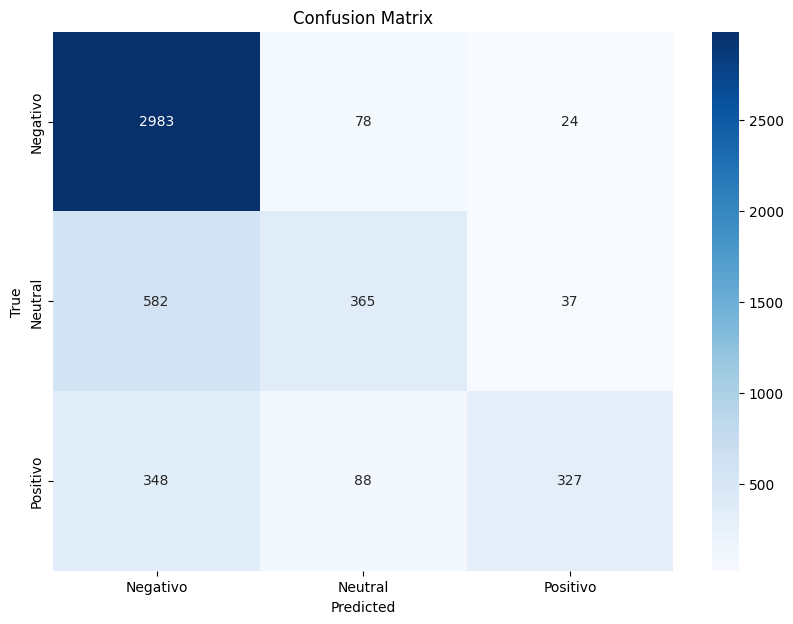

In [35]:
conf_matrix_modelo4 = confusion_matrix(y_test, predict_rf4)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_modelo4, annot=True, fmt='g', cmap='Blues', xticklabels=['Negativo', 'Neutral', 'Positivo'], yticklabels=['Negativo', 'Neutral', 'Positivo'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [36]:
cv4.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

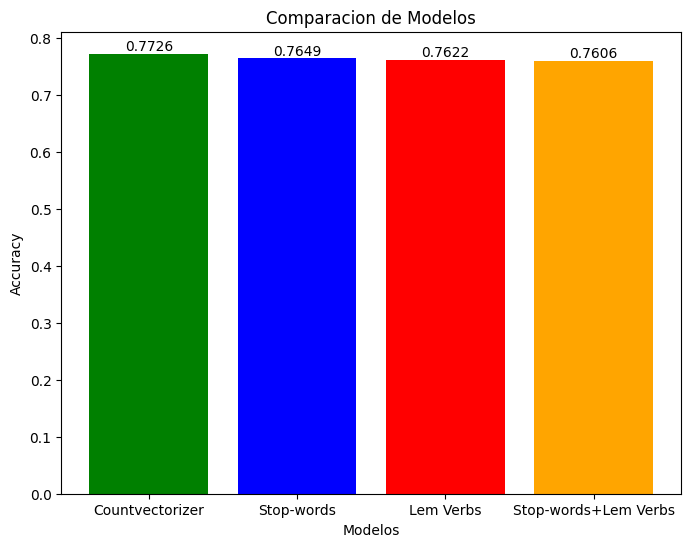

In [37]:

model_names = ['Countvectorizer', 'Stop-words', 'Lem Verbs', 'Stop-words+Lem Verbs']

accuracy_values = [accuracy_rf1,accuracy_rf2,accuracy_rf3,accuracy_rf4]

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracy_values, color=['green', 'blue', 'red', 'orange'])

plt.title('Comparacion de Modelos')
plt.xlabel('Modelos')
plt.ylabel('Accuracy')

for i in range(len(accuracy_values)):
    plt.text(i, accuracy_values[i], f'{accuracy_values[i]:.4f}', ha = 'center', va = 'bottom')

plt.show()

De acuerdo al resultado obtenido de los accuracy, podemos observar que el modelo donde procesamos los datos solamente con countvectorizer, obtuvimos un accuracy un poco superior a los demas. Esta forma de procesamiento solo captura la frecuencia de las palabras,  incluye términos comunes y formas verbales originales, lo que parece ser beneficioso a la hora de capturar los sentimientos en los comentarios de twitter. Adicionalemente, esta tecnica es una forma simple de preprocesar lo que ayuda con el consumo computacional a la hora de entrenar la data. La desventaja es que sufre de alta dimensionalidad que podria ocasionar sobre ajuste.

En cuanto a el modelo de menor desempeno, este fue el de Stop_words, lo que nos pudiera estar indicando que para la clasificacion de los sentimientos estamos perdiendo alguna informacion contextual. Eliminar palabras comunes, como "can't", "too", "much", "couldn't", "no" puede ser crucial para determinar correctamente el sentimiento de un comentario. Por ejemplo:

- "@SouthwestAir Weather keeps slowing us down. Not your fault. This is the 1st time a Southwest flight of mine was Late Flight so I can't complain :)"

- Etiqueta real: 1

- Predicción: -1


El caso anterior es un comentario positivo, sin embargo, es posible que al eliminar palabras como "not" o "can't" se transforme un comentario positivo en uno negativo, dado que en este caso, esas palabras son importantes para el contexto.

Por otra parte, podrían haber confusiones con comentarios positivos si se eliminan palabras como "no", "too" y "much", resultando en una clasificación errónea. Este enfoque es más ventajoso cuando queremos enfocarnos en palabras más específicas que tengan una mayor relevancia semántica y que sean más útiles para distinguir entre diferentes tipos de contenido, reduciendo así el número de características.

Hemos aplicado lematizacion de verbos como hemos visto en clases, sin embargo para el análisis de sentimiento de los tweets, es importante considerar tanto sustantivos como verbos, ya que ambos pueden llevar información sobre el sentimiento. Los verbos pueden expresar acciones como "amar", "odiar", mientras que los sustantivos pueden estar relacionados con opiniones positivas o negativas como "problema" o "ventaja". Hemos investigado que Spacy es una libreria muy potente para el procesamiento de lenguaje natural y es capaz de determinar si las palabras son sustantivos, verbos, adjetivos, o cualquier otra categoría gramatical, gracias a su potente sistema de etiquetado POS. Procedemos a correr el mismo modelo y obtuvimos un accuracy mayor de 77.58%

In [38]:
import spacy
en_nlp= spacy.load('en_core_web_sm') #Importamos BD para procesar palabras en ingles

def custom_tokenizer(text):
  doc_spacy= en_nlp(text)
  return [token.lemma_ for token in doc_spacy]


cv5 = CountVectorizer(lowercase=True,tokenizer=custom_tokenizer )


X_train_cv5 = cv5.fit_transform(X_train)
X_test_cv5 = cv5.transform(X_test)
X_train_cv5.shape

rf5 = RandomForestClassifier()
rf5.fit(X_train_cv5, y_train)
predict_rf5 = rf5.predict(X_test_cv5)

accuracy_rf5 = accuracy_score(y_test, predict_rf5)
print("Accuracy del modelo Random Forest:", accuracy_rf5)

Accuracy del modelo Random Forest: 0.7758692052980133


In [39]:
etiquetas_reales = y_test.values
fallos_indices = etiquetas_reales != predict_rf4
indices_fallos = [i for i, fallo in enumerate(fallos_indices) if fallo]
for indice in indices_fallos:
    print("Índice:", indice)
    print("Texto del tweet:", X_test.iloc[indice])
    print("Etiqueta real:", etiquetas_reales[indice])
    print("Predicción:", predict_rf4[indice])
    print()

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Índice: 673
Texto del tweet: @SouthwestAir Glad to know I'll be flying the luv airline tomorrow ;)
Etiqueta real: 1
Predicción: 0

Índice: 676
Texto del tweet: @USAirways have scheduled flight Sat(2morrow) CHO-CLT CHO needs to be added to weather advisory.  Please evaluate asap.
Etiqueta real: 0
Predicción: -1

Índice: 680
Texto del tweet: @AmericanAir Any way that we could look at other options for today?
Etiqueta real: 0
Predicción: -1

Índice: 681
Texto del tweet: @JetBlue im flying with you from mi-boston and then icelandair to iceland, 8 hours between. can we check our bags all the way?
Etiqueta real: 0
Predicción: -1

Índice: 683
Texto del tweet: @SouthwestAir @PHLAirport Will Flight 2155 that arrives at E11 be a penguin plane?
Etiqueta real: 0
Predicción: -1

Índice: 685
Texto del tweet: @USAirways the plane crew has been as professional and courteous as the gate agents were flustered.
Etiqueta real: 1
Predicción